In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import os


In [39]:

dataset_name = 'df_drop_appCat'
df = pd.read_csv(f'tables/preprocessed/{dataset_name}.csv')
df.head()

,id_num,mood,screen,activity,activity_max,circumplex.valence,circumplex.valence_min,circumplex.valence_max,circumplex.arousal,circumplex.arousal_min,circumplex.arousal_max,day,next_day,next_day_mood,date
0,1,6.20,17978.907000,3.083152,0.798387,0.2,0.0,1.0,0.2,-1.0,1.0,2014-03-21,2014-03-22 00:00:00,6.40,2014-03-21
1,1,6.40,6142.161000,3.790084,0.508475,0.5,-1.0,1.0,0.6,-1.0,1.0,2014-03-22,2014-03-23 00:00:00,6.80,2014-03-22
2,1,6.80,6773.832001,2.141117,0.313559,0.8,0.0,1.0,0.2,-1.0,1.0,2014-03-23,2014-03-24 00:00:00,6.00,2014-03-23
3,1,6.00,15047.351001,1.895065,0.361345,0.0,-1.0,1.0,0.8,-1.0,2.0,2014-03-24,2014-03-25 00:00:00,6.75,2014-03-24
4,1,6.75,21475.354999,2.360979,0.594828,0.5,0.0,1.0,0.5,-1.0,1.0,2014-03-25,2014-03-26 00:00:00,6.60,2014-03-25


In [40]:
# select everything except day, date, next_day
X = df.drop(columns=['day', 'date', 'next_day', "next_day_mood", "id_num"])

X = df["mood"].values.reshape(-1, 1)
y = df['next_day_mood']

# get dummies for id_num
# X = pd.get_dummies(X, columns=['id_num'])

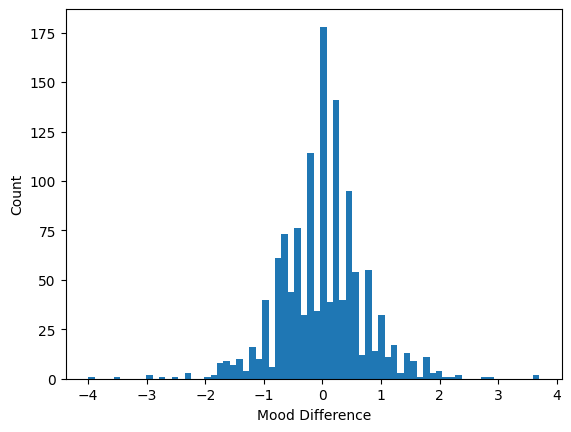

In [49]:
difference = df['next_day_mood'] - df['mood']

plt.hist(difference, bins=70)
plt.ylabel('Count')
plt.xlabel('Mood Difference')
plt.show()

                         R2  R2_train       MAE MAE_train       MSE MSE_train  \
Linear Regression  0.206195  0.240461   0.47499  0.462606  0.440069  0.391605   
Ridge Regression   0.205517  0.239569  0.473904  0.463685  0.440444  0.392065   
Random Forest      0.164351  0.299893  0.492697   0.44399  0.463266  0.360963   
XGBoost Regressor  0.160112  0.305265   0.49445  0.438311  0.465616  0.358193   
Decision Tree       0.15848  0.305268  0.495067  0.438177  0.466521  0.358192   
Lasso Regression  -0.012301       0.0  0.535948  0.533618  0.561198  0.515583   
Elastic Net       -0.012301       0.0  0.535948  0.533618  0.561198  0.515583   

                       RMSE RMSE_train         dataset  
Linear Regression  0.663377   0.625784  df_drop_appCat  
Ridge Regression    0.66366   0.626151  df_drop_appCat  
Random Forest      0.680636   0.600802  df_drop_appCat  
XGBoost Regressor  0.682361   0.598493  df_drop_appCat  
Decision Tree      0.683023   0.598492  df_drop_appCat  
Lasso Reg

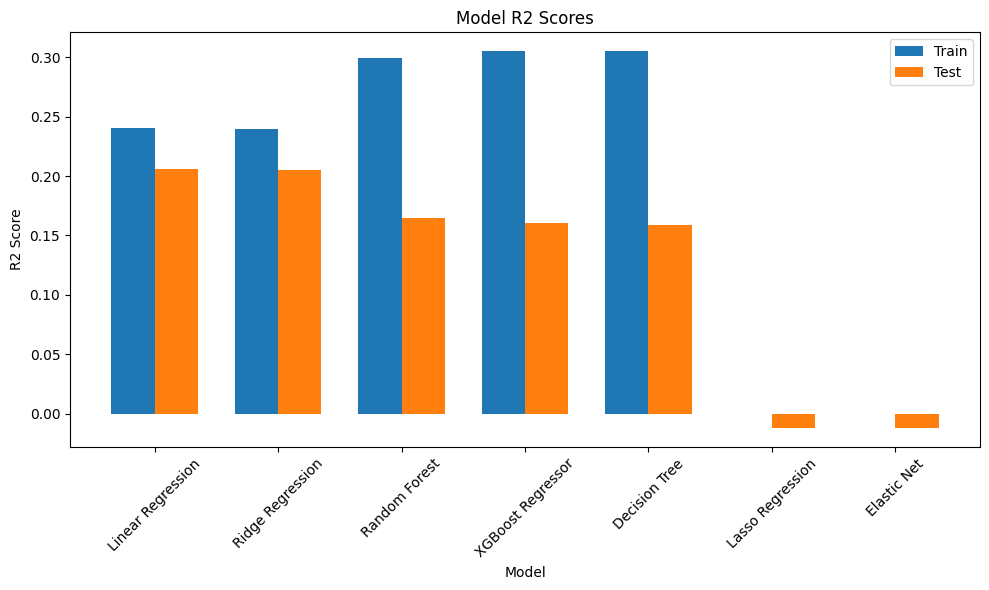

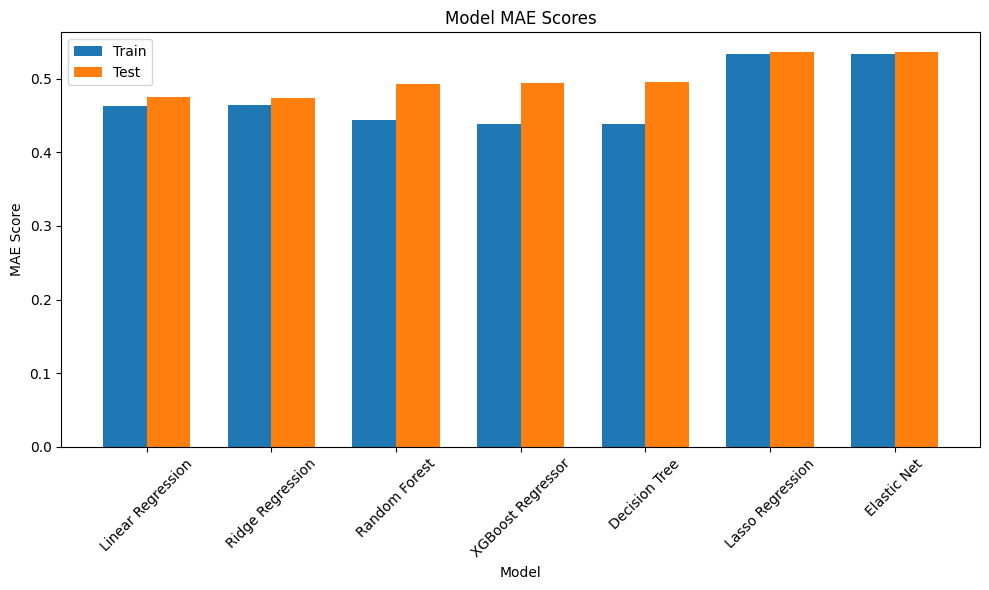

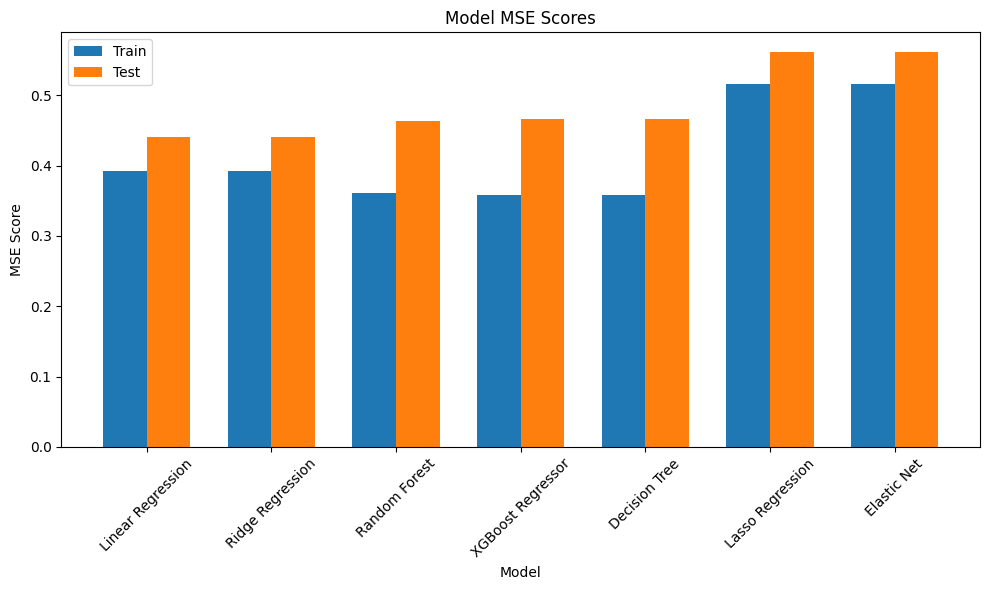

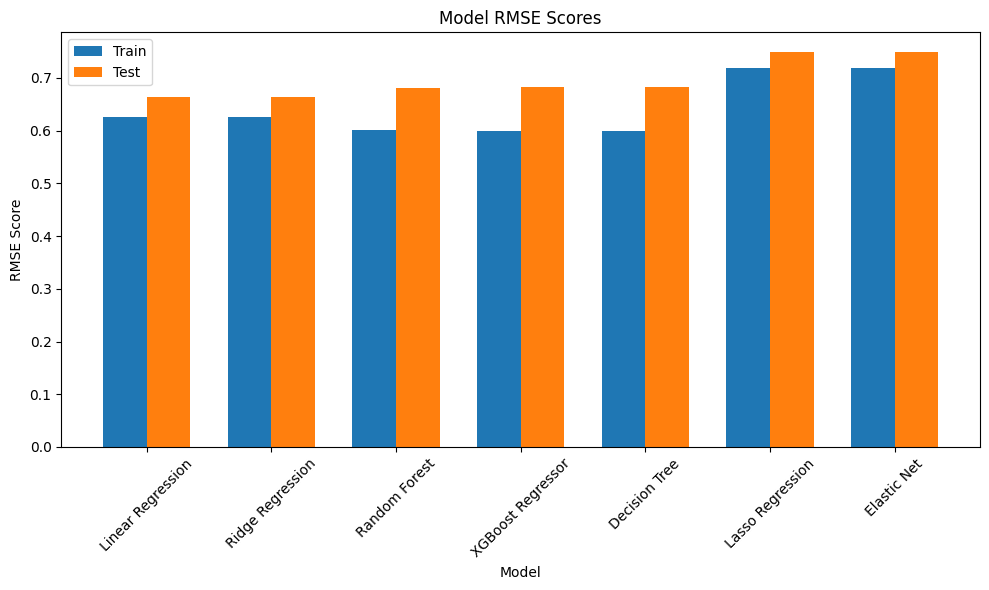

In [41]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# define models
models = {
    'Linear Regression': LinearRegression(), 
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(), 
    'XGBoost Regressor': XGBRegressor()
}
# fit models and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    y_pred_train = model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    results[name] = {
        'R2': r2,
        'R2_train': r2_train,
        'MAE': mae,
        'MAE_train': mae_train,
        'MSE': mse,
        'MSE_train': mse_train,
        'RMSE': rmse,
        'RMSE_train': rmse_train,
        'dataset': dataset_name
    }
# print results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

# plot R2 scores
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df.index))  # the label locations
width = 0.35  # the width of the bars
plt.bar(x - width/2, results_df['R2_train'], width, label='Train')
plt.bar(x + width/2, results_df['R2'], width, label='Test')
plt.title('Model R2 Scores')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_r2_scores.png')
plt.show()

# plot MAE scores
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, results_df['MAE_train'], width, label='Train')
plt.bar(x + width/2, results_df['MAE'], width, label='Test')
plt.title('Model MAE Scores')
plt.xlabel('Model')
plt.ylabel('MAE Score')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_mae_scores.png')
plt.show()

# plot MSE scores
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, results_df['MSE_train'], width, label='Train')
plt.bar(x + width/2, results_df['MSE'], width, label='Test')
plt.title('Model MSE Scores')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_mse_scores.png')
plt.show()

# plot RMSE scores
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, results_df['RMSE_train'], width, label='Train')
plt.bar(x + width/2, results_df['RMSE'], width, label='Test')
plt.title('Model RMSE Scores')
plt.xlabel('Model')
plt.ylabel('RMSE Score')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_rmse_scores.png')
plt.show()

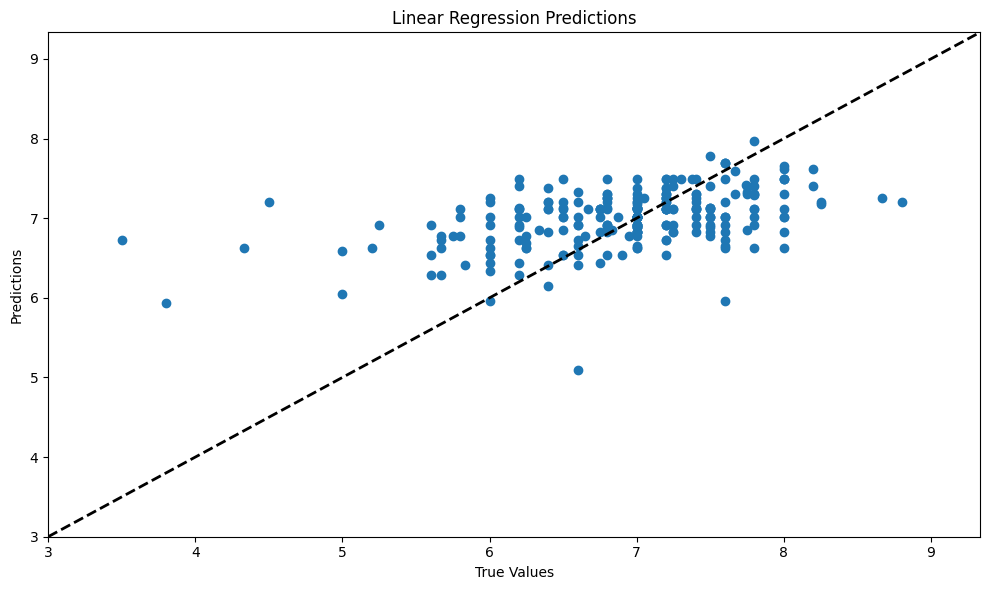

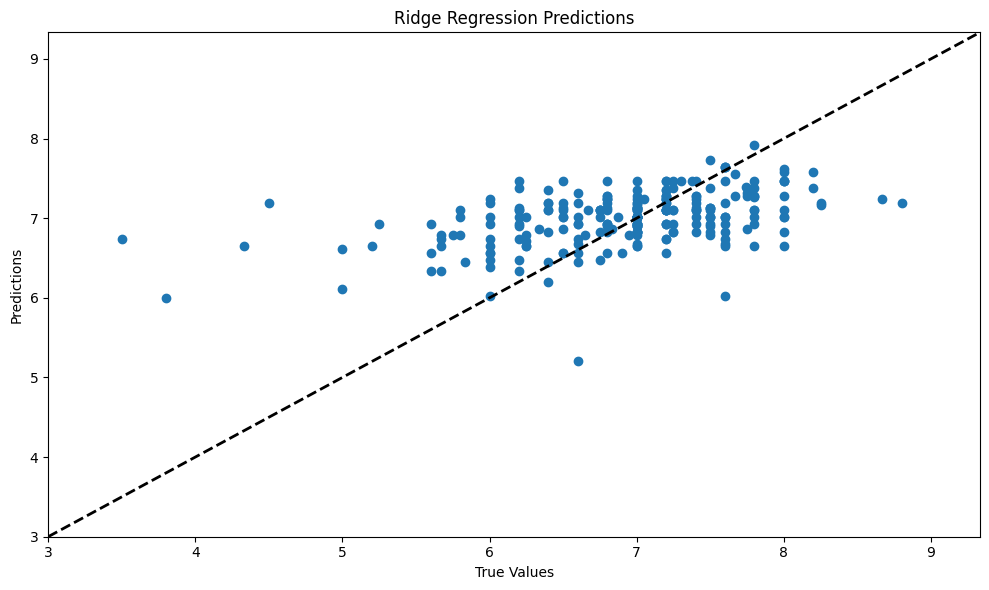

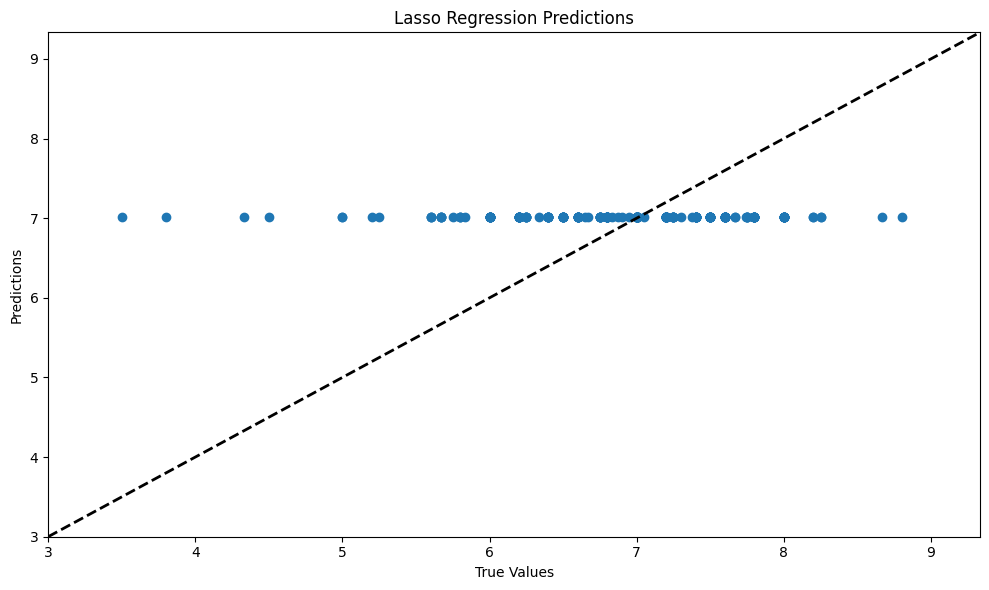

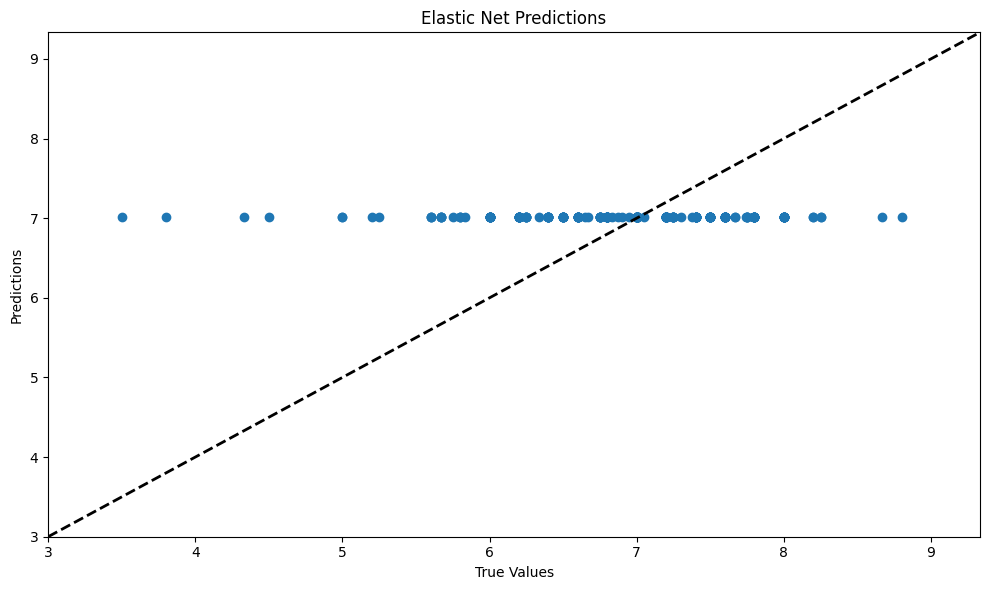

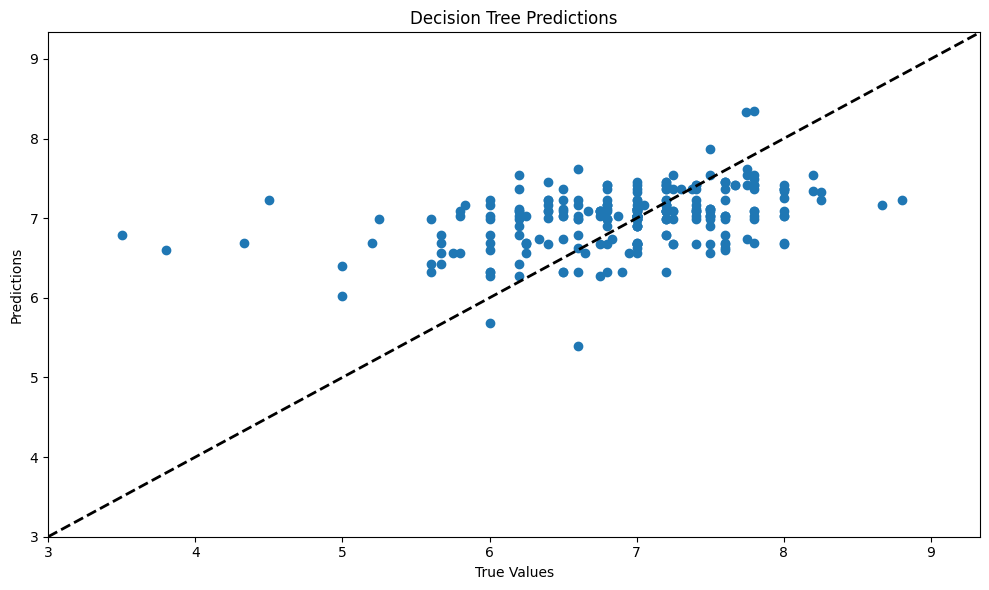

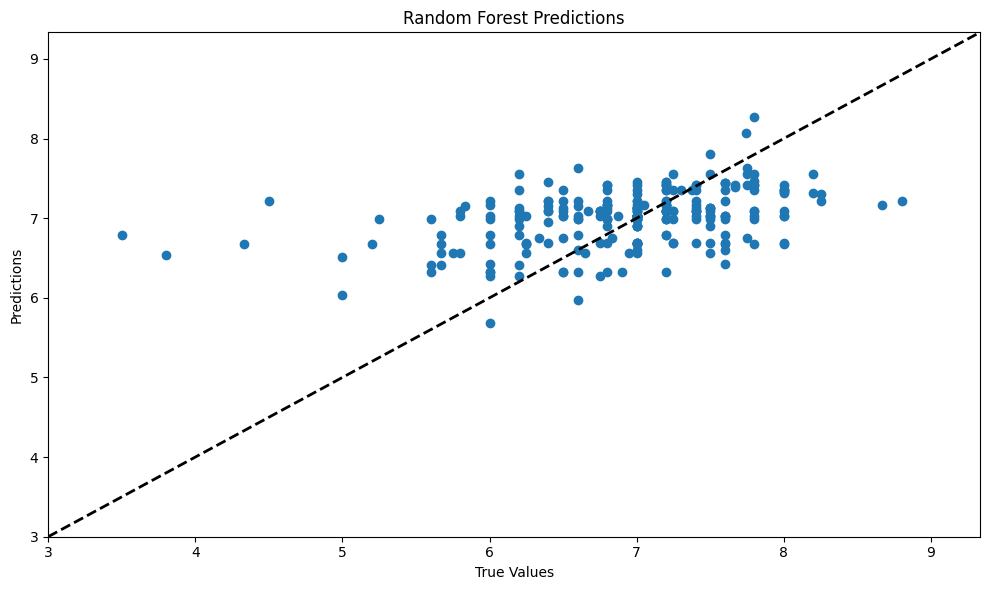

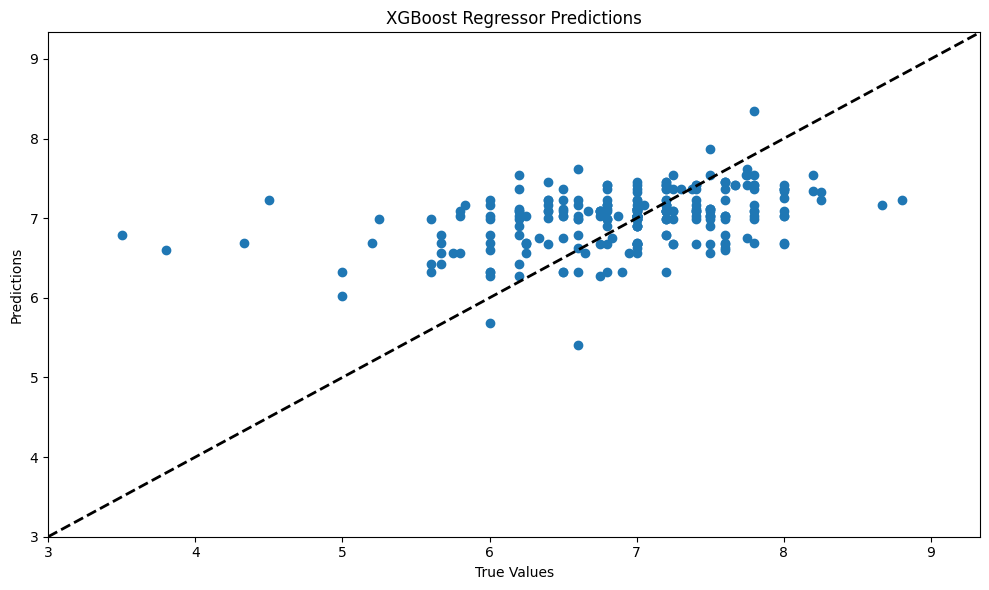

In [42]:
# plot predictions
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.title(f'{name} Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlim(y.min(), y.max())
    plt.ylim(y.min(), y.max())
    plt.tight_layout()
    # plt.savefig(f'tables/preprocessed/{name}_predictions.png')
    plt.show()
    

In [43]:
# feature importance 
importances = {}
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances[name] = model.coef_
    else:
        importances[name] = None
# plot feature importances
for name, importance in importances.items():
    if importance is not None:
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, importance)
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        # plt.savefig(f'tables/preprocessed/{name}_feature_importances.png')
        plt.show()
    else:
        print(f'{name} does not have feature importances.')


# save results to csv
if not os.path.exists('tables/results'):
    os.makedirs('tables/results')
    results_df.to_csv('tables/results/model_results.csv', index=True, header=True)
results_df.to_csv("tables/results/model_results.csv", mode='a', header=False, index=True)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 1000x600 with 0 Axes>